C:\Users\kilio\AppData\Local\Temp\ipykernel_5612\3754662892.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Matches found: ['image_04001_eth_0.png', 'image_04001_html_0.png', 'image_04001_url_0.png']
Selected stego image: stegoimagesdataset/test/test/stego\image_04001_eth_0.png
Processing: stegoimagesdataset/test/test/clean\04001.png with noise: none


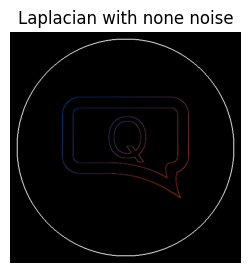

Prédiction : Clean (Probas: Clean=1.000, Stego=0.000)
Processing: stegoimagesdataset/test/test/stego\image_04001_eth_0.png with noise: none


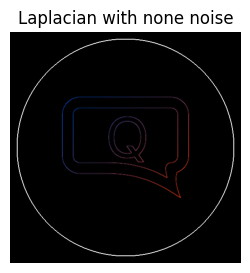

Prédiction : Stego (Probas: Clean=0.002, Stego=0.998)


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import os
import random


def add_gaussian_noise(img_np, mean=0, std=10):
    noise = np.random.normal(mean, std, img_np.shape).astype(np.float32)
    noisy = img_np.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(img_np, amount=0.01):
    output = img_np.copy()
    num_salt = int(np.ceil(amount * img_np.size * 0.5))
    coords = [np.random.randint(0, i - 1, num_salt) for i in img_np.shape[:2]]
    output[coords[0], coords[1]] = 255

    num_pepper = int(np.ceil(amount * img_np.size * 0.5))
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img_np.shape[:2]]
    output[coords[0], coords[1]] = 0
    return output

def add_blur(img_np, kernel_size=3):
    return cv2.blur(img_np, (kernel_size, kernel_size))

def apply_laplacian_rgb(img_pil, noise="none"):
    img_np = np.array(img_pil)

    if noise == "gaussian":
        img_np = add_gaussian_noise(img_np)
    elif noise == "salt_pepper":
        img_np = add_salt_pepper_noise(img_np)
    elif noise == "blur":
        img_np = add_blur(img_np)

    laplacian_channels = []
    for c in range(3):
        channel = img_np[:, :, c]
        lap = cv2.Laplacian(channel, cv2.CV_32F)
        lap = cv2.convertScaleAbs(lap)
        laplacian_channels.append(lap)

    img_lap = np.stack(laplacian_channels, axis=-1)
    return Image.fromarray(img_lap)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, 2)
)


model_path = "Models/Thebestsofar/maybe2.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(model_path))
model = model.to(device).eval()

clean_img = "04001.png"
clean_dir = "stegoimagesdataset/test/test/clean"
stego_dir = "stegoimagesdataset/test/test/stego"

clean_path = os.path.join(clean_dir, clean_img)
base_id = os.path.splitext(clean_img)[0]
pattern = f"image_{base_id}_.+\\.png"
stego_matches = [f for f in os.listdir(stego_dir) if re.match(pattern, f)]
if stego_matches:
    print(f"Matches found: {stego_matches}")
    stego_img = random.choice(stego_matches)
    stego_path = os.path.join(stego_dir, stego_img)

if stego_path:
    print(f"Selected stego image: {stego_path}")
    images = [clean_path, stego_path]
else:
    print("No matching stego image found.")
    images = [clean_path]

noise_type = "none"  # "none", "gaussian", "salt_pepper", "blur"

for image_path in images:
    print(f"Processing: {image_path} with noise: {noise_type}")
    img = Image.open(image_path).convert("RGB")
    img_lap = apply_laplacian_rgb(img, noise=noise_type)
    plt.figure(figsize=(3, 3))
    plt.imshow(img_lap)
    plt.title(f"Laplacian with {noise_type} noise")
    plt.axis('off')
    plt.show()
    input_tensor = transform(img_lap).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()

    print(f"Prédiction : {'Stego' if pred == 1 else 'Clean'} (Probas: Clean={prob[0,0]:.3f}, Stego={prob[0,1]:.3f})")


C:\Users\kilio\AppData\Local\Temp\ipykernel_5612\1865553390.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


              precision    recall  f1-score   support

       Clean       0.00      0.00      0.00         0
       Stego       1.00      0.96      0.98      1000

    accuracy                           0.96      1000
   macro avg       0.50      0.48      0.49      1000
weighted avg       1.00      0.96      0.98      1000



d:\anaconda3\envs\torch_cuda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\torch_cuda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\torch_cuda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


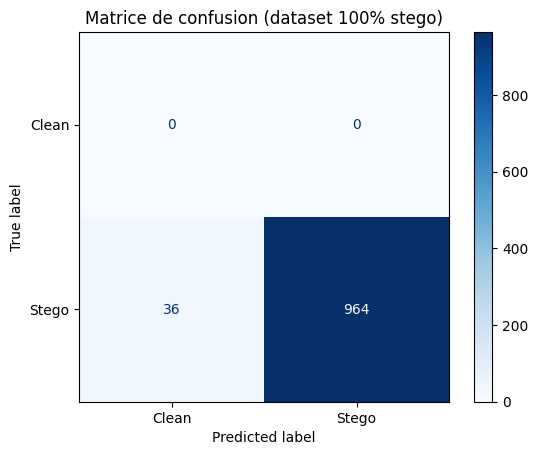

In [3]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from PIL import Image
import cv2
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

stego_dir = "other_dataset"
num_samples = 1000

model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, 2)
)
model_path = "Models/Thebestsofar/maybe2.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path))
model = model.to(device).eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def apply_laplacian_rgb(img_pil, noise="none"):
    img_np = np.array(img_pil)

    if noise == "gaussian":
        img_np = add_gaussian_noise(img_np)
    elif noise == "salt_pepper":
        img_np = add_salt_pepper_noise(img_np)
    elif noise == "blur":
        img_np = add_blur(img_np)

    laplacian_channels = []
    for c in range(3):
        channel = img_np[:, :, c]
        lap = cv2.Laplacian(channel, cv2.CV_32F)
        lap = cv2.convertScaleAbs(lap)
        laplacian_channels.append(lap)

    img_lap = np.stack(laplacian_channels, axis=-1)
    return Image.fromarray(img_lap)



image_files = [f for f in os.listdir(stego_dir) if f.endswith('.png')]
image_files = random.sample(image_files, min(len(image_files), num_samples))

y_true, y_pred = [], []

with torch.no_grad():
    for file in image_files:
        img = Image.open(os.path.join(stego_dir, file)).convert("RGB")
        img_lap = apply_laplacian_rgb(img, noise="none")
        input_tensor = transform(img_lap).unsqueeze(0).to(device)
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        
        y_true.append(1)
        y_pred.append(pred)

print(classification_report(y_true, y_pred, target_names=["Clean", "Stego"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clean", "Stego"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion (dataset 100% stego)")
plt.show()
